In [1]:
import os,sys
sys.path.append('../..')
sys.path.append('../../../gempy/')
import sandbox.sandbox as sb

import gempy as gp
#import gempy_sandbox a   s gpsb
import numpy as np
#from PIL import Image, ImageDraw
import pickle

../../../gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../../gempy/gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")
../../sandbox/sandbox.py:34: RuntimeWarning: Two kernels cannot access the kinect at the same time. This will lead to a sudden death of the kernel. Be sure no other kernel is running before initialize a kinect object.
  'Be sure no other kernel is running before initialize a kinect object.', RuntimeWarning)


### Set up the sandbox 

First we activate the kinect

In [2]:
kinect = sb.Kinect(dummy=True)

dummy mode. get_frame() will return a synthetic depth frame, other functions may not work


Now we can set up the projector settings:

In [3]:
projector = sb.Projector(resolution = (1024,768), work_directory='./temp',
                        refresh=100, input_rescale=False)

Next is to pass the calibration---kinect-projector---to the projector class to be able to project just on the sandbox

In [4]:
calibration_filename = "sandbox_brisbane.dat" 
calibration = sb.Calibration(projector)
calibration.load(calibration_file=calibration_filename)
projector.set_calibration(calibration)
projector.start_stream()   

calibration data file not found. Using default values


Also we need to set up the general options of Matplotlib (the library to create the models). Here we are passing the colors of GemPy simply for consistency.

In [5]:
plot_im = sb.Plot(
    calibration=calibration,
    cmap=gp.plotting.colors.cmap,
    norm=gp.plotting.colors.norm
    )

### Setup the model gempy model

Now we need to generate the map that we want to poject. In the case of a geological map we will use GemPy.

First we need to load the underlaying 3D model. We can find some examples in the GemPy library

In [6]:
geo_model = gp.read_pickle(r'../../../gempy/notebooks/examples/Models_Lisa/lisa-1.pickle')

We want to scale the sandbox to the model extent. We can see a gempy model extent by

In [7]:
geo_model._geo_data.extent

array([   0, 2000,    0, 2000,    0, 1600])

In [8]:
# pass that extent
model_extent = geo_model._geo_data.extent

### Create sandbox grid following the right scale sandbox-model

Now we need to connect the cloud of points recorded by the kinect to the scale of geological model

In [9]:
scale=sb.Scale(extent=model_extent, calibration=calibration) #initialize scale object to handle the scaling of the model in the andbox
scale.calculate_scales()
grid = sb.Grid(calibration=calibration,scale=scale)

Aspect ratio of the model is fixed in XY
Model size is limited by Y dimension
scale in Model units/ mm (X,Y,Z): [2.666666666666667, 3.3333333333333335, 2.6666666666666665]
the shown extent is [0.0, 2662.5, 0.0, 1995.8333333333335] 


### Create the GeoMap module for the Sandbox

To increase the flexibility of the sandbox and generalize the hyperthreading (i.e. getting the sandbox running without blocking python), we have create a modules systems. This modules are classes that encapsulate the specific functionality for each type of map that we want to render. Lets create the geological map module.

In [10]:
projector.work_directory

'./temp'

In [11]:
geo_module = sb.GeoMapModule(geo_model, grid, plot_im,
                             work_directory=projector.work_directory)

In [12]:
geo_module.render_geo_map(*geo_module.compute_model(kinect.get_filtered_frame()))

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


### Hyperthreading

In [13]:
s_thread = sb.SandboxThread(geo_module, kinect, projector)

In [14]:
s_thread.run()

In [14]:
s_thread.kill()

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/miguel/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/miguel/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "../../sandbox/sandbox.py", line 1300, in loop
    self.module.render_geo_map(lith, fault, outfile=self.path)
  File "../../sandbox/sandbox.py", line 1177, in render_geo_map
    self.geol_map.save(outfile=outfile)
  File "../../sandbox/sandbox.py", line 795, in save
    self.fig.savefig (self.outfile, pad_inc

- Change lines in real time
- fault on and off
- change the model

In [16]:
with s_thread.lock:
    geo_module.plot_topography =True

### Save geological map

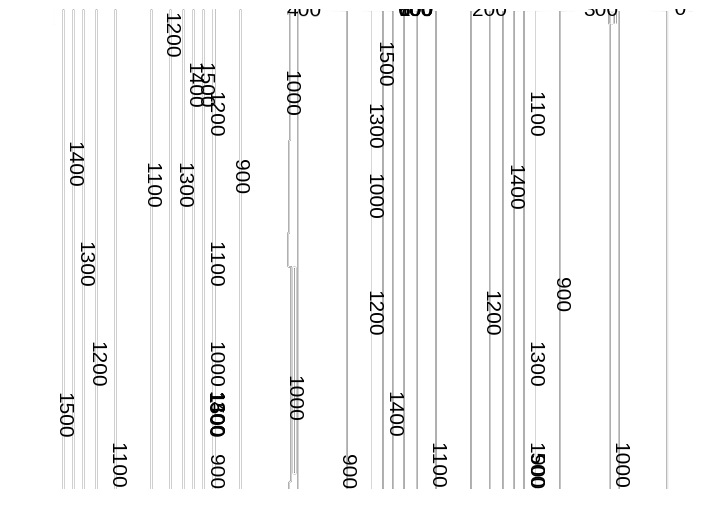

In [15]:
#with s_thread.lock:
geo_module.export_topographic_map('topographic_map.pdf')

In [19]:
with s_thread.lock:
    geo_module.export_geological_map(kinect.get_filtered_frame(),
                                     'geological_map.pdf')

there is still a bug in the map that causes the uppermost lithology to be displayed in the basement color. Unfortunately we do not have a quick fix for this currently... Sorry! Please fix the map yourself, for example using illustrator


### Toggle fault visibility

In [ ]:
geology.pause()
if geology.module.show_faults is True:
    geology.module.show_faults = False
else:
    geology.module.show_faults = True
geology.resume()

## change contour levels 

In [ ]:
#TODO

#        self.fig = plt.figure(figsize=(self.w, self.h), dpi=100, frameon=False)
#         self.ax = plt.Axes(self.fig, [0., 0., 1., 1.])
#         self.ax.set_axis_off()
#         self.fig.add_axes(self.ax)

# geology.pause()
# start = 0
# end = 2000
# main_step = 50
# sub_step = 10

# geology.module.main_contours = np.arange(start, end, main_step)
# geology.module.sub_contours = np.arange(start, end, sub_step)
# geology.resume()

In [ ]:
gp.plot.plot_surfaces_3D(geo_model_3d)
